In [16]:
# IMPORTING MODULES
import glob
import importlib
import heartpy as hp
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import os
import pandas as pd
import scipy.signal as ss
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

import tools.data_reader_wesad as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing

from scipy.fft import fft, fftfreq, fftshift

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

In [2]:
# HELPER METHODS
import samplerate
import scipy

def get_time_segments(subject, sr_to_convert=0):
    data = dr.get_participant_data(subject)
    labels = data["label"]
    if sr_to_convert > 0:
        step = int(700/sr_to_convert)
        resampled = []
        for i in range(0, labels.size, step):
            resampled.append(labels[i])
        labels = np.asarray(resampled)
        # labels = samplerate.resample(labels, sr_to_convert/700.0)
        # labels = scipy.signal.decimate(labels, int(700.0/sr_to_convert))
    curr_value = labels[0]
    start_indices = [0]
    end_indices = []
    i = 1
    while i < len(labels):
        if labels[i] != curr_value:
            end_indices.append(i-1)
            start_indices.append(i)
            curr_value = labels[i]
        i += 1

    end_indices.append(len(labels)-1)

    time_segments = {}
    for i in range(len(start_indices)):
        label = labels[start_indices[i]]
        if label not in time_segments.keys():
            time_segments[label] = [(start_indices[i], end_indices[i])]
        else:
            time_segments[label].append((start_indices[i], end_indices[i]))
    return time_segments


# ts = get_time_segments(2)
# print(ts)

In [ ]:
# # SAVE SIGNALS INTO INDIVIDUAL CSV FILES
# importlib.reload(dr)
# importlib.reload(dt)
# importlib.reload(preprocessing)


# subject_indices = list(range(2, 12)) + list(range(13, 18))
# subject_indices = [str(i) for i in subject_indices]

# locations = [dr.WESADKeys.CHEST]
# # locations = [dr.WESADKeys.WRIST]
# chest_signals = [
#     # dr.Signals.ACC, dr.Signals.ECG, dr.Signals.EDA, dr.Signals.EMG, "Resp", "Temp"
#     dr.Signals.ECG, dr.Signals.EDA, 
# ]
# wrist_signals = [
#     dr.Signals.ACC, dr.Signals.BVP, dr.Signals.EDA, dr.Signals.TEMP
# ]
# phase_label_dict = {
#     1: dr.Phases.BASE,
#     2: dr.Phases.TSST,
#     3: dr.Phases.FUN,
#     4: [dr.Phases.MEDI_1, dr.Phases.MEDI_2]
# }

# phases = dr.Phases.PHASE_ORDER
# # location = "wrist"
# location = "chest"

# for subject in subject_indices:
#     data = dr.get_participant_data(subject)
    
#     for signal in chest_signals:
#     # for signal in wrist_signals:
#         if location == "wrist":
#             sr = dr.FS_DICT["wrist"][signal]
#         else:
#             sr = 700.0
#         time_segments = get_time_segments(subject, sr)
#         signal_data = data["signal"][location][signal]
#         for label in list(phase_label_dict.keys()):
#             if signal == "Temp" or signal == "Resp":
#                 signal = signal.upper()
#             phase = phase_label_dict[label]
#             if label == 4:  # 4 corresponds to MEDI 1 and MEDI 2; includes 2 time segment tuples
#                 if signal == dr.Signals.ACC:
#                     columns_1 = [f"{location}_{signal}_X_{phase[0]}", f"{location}_{signal}_Y_{phase[0]}", f"{location}_{signal}_Z_{phase[0]}"]
#                 else: 
#                     columns_1 = [f"{location}_{signal}_{phase[0]}"]
#                 file_name_1 = f"S{subject}_{location}_{signal}_{phase[0]}.csv"
#                 file_name_1 = os.path.join(dr.Paths.WESAD, f"S{subject}", file_name_1)
#                 start = time_segments[label][0][0]
#                 end = time_segments[label][0][1]
#                 phase_data = signal_data[start:end]
#                 phase_data = pd.DataFrame(data=phase_data, columns=columns_1)
#                 phase_data.to_csv(file_name_1)

#                 if signal == dr.Signals.ACC:
#                     columns_2 = [f"{location}_{signal}_X_{phase[1]}", f"{location}_{signal}_Y_{phase[1]}", f"{location}_{signal}_Z_{phase[1]}"]
#                 else: 
#                     columns_2 = [f"{location}_{signal}_{phase[1]}"]
#                 file_name_2 = f"S{subject}_{location}_{signal}_{phase[1]}.csv"
#                 file_name_2 = os.path.join(dr.Paths.WESAD, f"S{subject}", file_name_2)
#                 start = time_segments[label][1][0]
#                 end = time_segments[label][1][1]
#                 phase_data = signal_data[start:end]
#                 phase_data = pd.DataFrame(data=phase_data, columns=columns_2)
#                 phase_data.to_csv(file_name_2)
#             else:
#                 if signal == dr.Signals.ACC:
#                     columns = [f"{location}_{signal}_X_{phase}", f"{location}_{signal}_Y_{phase}", f"{location}_{signal}_Z_{phase}"]
#                 else: 
#                     columns = [f"{location}_{signal}_{phase}"]
#                 file_name = f"S{subject}_{location}_{signal}_{phase}.csv"
#                 file_name = os.path.join(dr.Paths.WESAD, f"S{subject}", file_name)
#                 start = time_segments[label][0][0]
#                 end = time_segments[label][0][1]
#                 phase_data = signal_data[start:end]
#                 phase_data = pd.DataFrame(data=phase_data, columns=columns)
#                 phase_data.to_csv(file_name)


In [ ]:
# ECG METRICS
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from biosppy.signals import ecg
import heartpy
import pyhrv
import pyhrv.time_domain as td

phases = dr.Phases.PHASE_ORDER
metric = "bpm"
subject_indices = dr.SUBJECTS
subject_indices = [str(i) for i in subject_indices]
fs = 700.0

for phase in phases:
    print(phase)
    data = []
    data_files = {
        s: dr.Paths.WESAD + f"/S{s}/S{s}_chest_ECG_{phase}.csv" for s in subject_indices
    }
    df_dict = {s: pd.read_csv(data_files[s]) for s in list(data_files.keys())}
    for s in list(df_dict.keys()):
        df = df_dict[s]
        ecg_signal = df.iloc[:, -1]
        
        bpm = preprocessing.get_bpm_biosppy(ecg_signal, fs=fs)

        bpm.insert(0, int(s))
        data.append(bpm)

    # file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
    # df = pd.DataFrame(data=data)
    # df.to_csv(file_name)

In [7]:
# ECG METRICS
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from biosppy.signals import ecg
import heartpy
import pyhrv
import pyhrv.time_domain as td

phases = dr.Phases.PHASE_ORDER
subject_indices = dr.SUBJECTS
subject_indices = [str(i) for i in subject_indices]
fs = 700.0

for phase in phases:
    print(phase)
    data_files = {
        s: dr.Paths.WESAD + f"/S{s}/S{s}_chest_ECG_{phase}.csv" for s in subject_indices
    }
    df_dict = {s: pd.read_csv(data_files[s]) for s in list(data_files.keys())}
    metrics_dict = {
        "bpm": [],
        "rmssd": [],
        "sdnn": []
    }
    for s in list(df_dict.keys()):
        df = df_dict[s]
        ecg_signal = df.iloc[:, -1]
        
        ecg_features = preprocessing.get_ecg_metrics(ecg_signal, fs=fs)
        
        for metric in list(metrics_dict.keys()):
            feature = ecg_features[metric]
            feature.insert(0, int(s))
            metrics_dict[metric].append(feature)

    for metric in list(metrics_dict.keys()):
        df = pd.DataFrame(metrics_dict[metric])
        metrics_dict[metric] = df
    for metric in list(metrics_dict.keys()):
        file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
        metrics_dict[metric].to_csv(file_name)

Base
TSST
Medi_1
Fun
Medi_2


In [11]:
# HF and LF metrics
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

from biosppy.signals import ecg


phases = dr.Phases.PHASE_ORDER
subject_indices = dr.SUBJECTS
fs = 700.0

for phase in phases:
    data_files = {
        s: dr.Paths.WESAD + f"/S{s}/S{s}_chest_ECG_{phase}.csv" for s in subject_indices
    }
    df_dict = {s: pd.read_csv(data_files[s]) for s in list(data_files.keys())}
    metrics_dict = {
        "lf_rr": [],
        "hf_rr": [],
    }
    for s in list(df_dict.keys()):
        df = df_dict[s]
        ecg_signal = df.iloc[:, -1]
        lf_rr = preprocessing.get_lf_rr(ecg_signal, fs)
        lf_rr = np.insert(lf_rr, 0, s)
        lf_rr = pd.DataFrame(lf_rr).dropna(axis=1)

        hf_rr = preprocessing.get_hf_rr(ecg_signal, fs)
        hf_rr = np.insert(hf_rr, 0, s)
        hf_rr = pd.DataFrame(hf_rr).dropna(axis=1)

        metrics_dict["lf_rr"].append(lf_rr)
        metrics_dict["hf_rr"].append(hf_rr)

    for metric in list(metrics_dict.keys()):
        df = pd.concat(metrics_dict[metric], axis=1)
        df = df.transpose()
        metrics_dict[metric] = df
    for metric in list(metrics_dict.keys()):
        file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
        metrics_dict[metric].to_csv(file_name)

In [20]:
# FEATURE EXTRACTION - EDA
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
import samplerate
from biosppy.signals import ecg
from biosppy.signals import eda
from heartpy.preprocessing import scale_data


phases = dr.Phases.PHASE_ORDER
# phases = [dr.Phases.PHASE_ORDER[0]]
subject_indices = dr.SUBJECTS
fs = 250.0

for phase in phases:
    print(f"{phase}")
    data_files = {
        s: dr.Paths.WESAD + f"/S{s}/S{s}_chest_EDA_{phase}.csv" for s in subject_indices
    }
    df_dict = {s: pd.read_csv(data_files[s]) for s in list(data_files.keys())}
    metrics_dict = {
        "mean_SCL": [],
        "SCR_rate": [],
    }
    for s in subject_indices:
        df = pd.read_csv(data_files[s])
        eda_signal = df.iloc[:, -1]
        eda_signal = scale_data(eda_signal)
        eda_signal = samplerate.resample(eda_signal, 250.0/700.0)

        mean_scl = preprocessing.get_mean_SCL(eda_signal, fs)
        mean_scl = np.insert(mean_scl, 0, s)
        mean_scl = pd.DataFrame(mean_scl).dropna(axis=1)

        scr_rate = preprocessing.get_SCR_rate(eda_signal, fs)
        scr_rate = np.insert(scr_rate, 0, s)
        scr_rate = pd.DataFrame(scr_rate).dropna(axis=1)

        metrics_dict["mean_SCL"].append(mean_scl)
        metrics_dict["SCR_rate"].append(scr_rate)

    for metric in list(metrics_dict.keys()):
        df = pd.concat(metrics_dict[metric], axis=1)
        df = df.transpose()
        metrics_dict[metric] = df
        
    for metric in list(metrics_dict.keys()):
        file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
        metrics_dict[metric].to_csv(file_name)

Base
TSST
Medi_1
Fun
Medi_2


Base


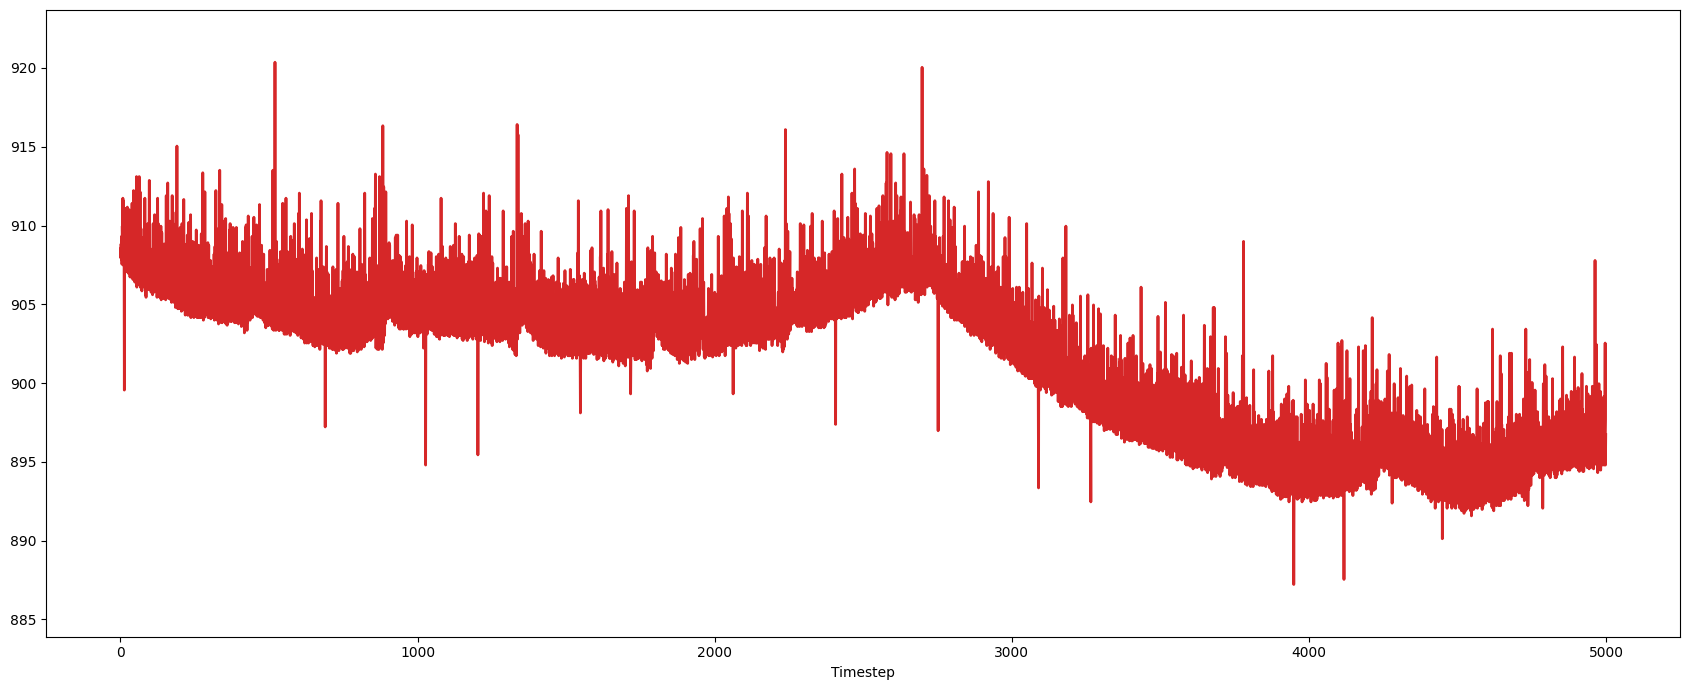

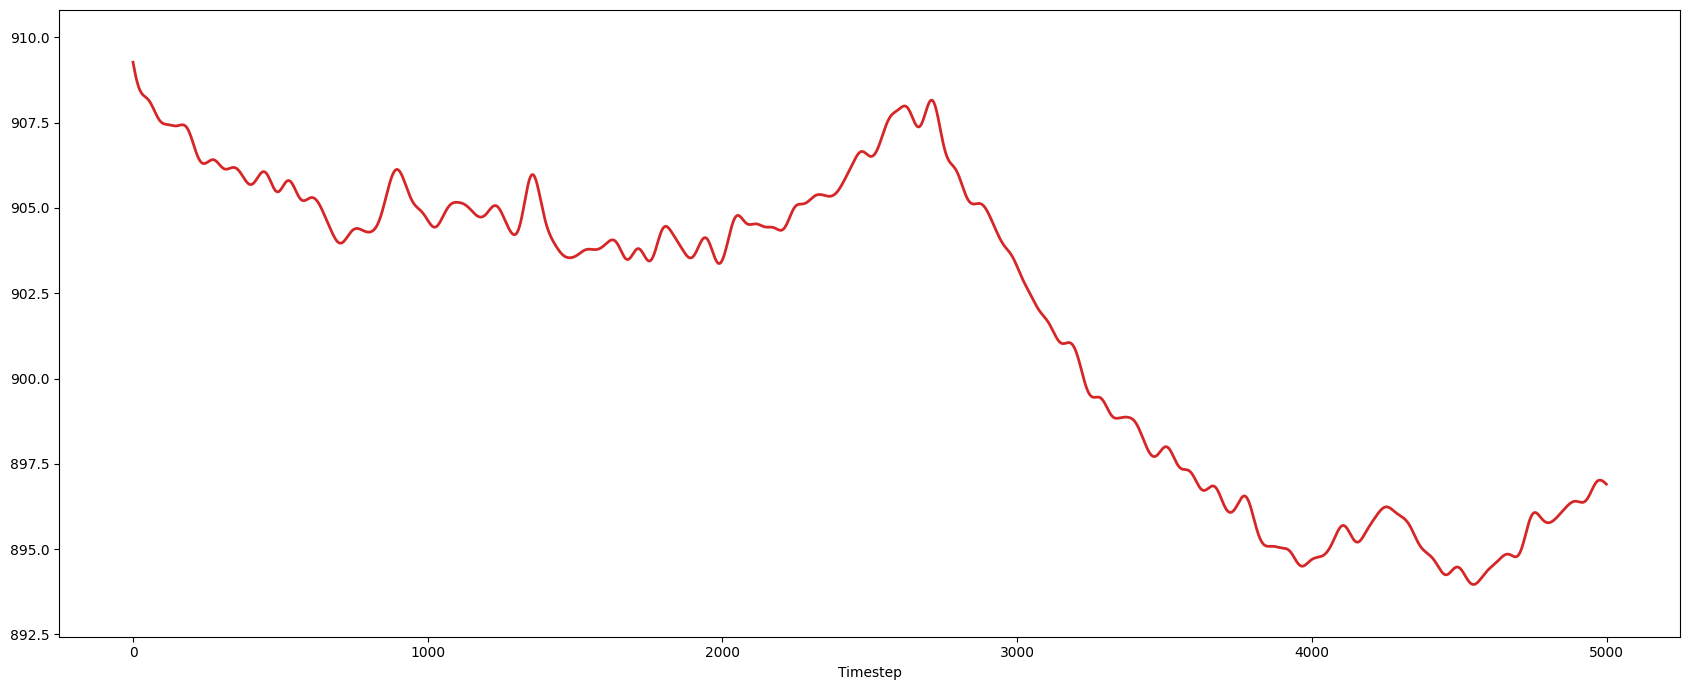

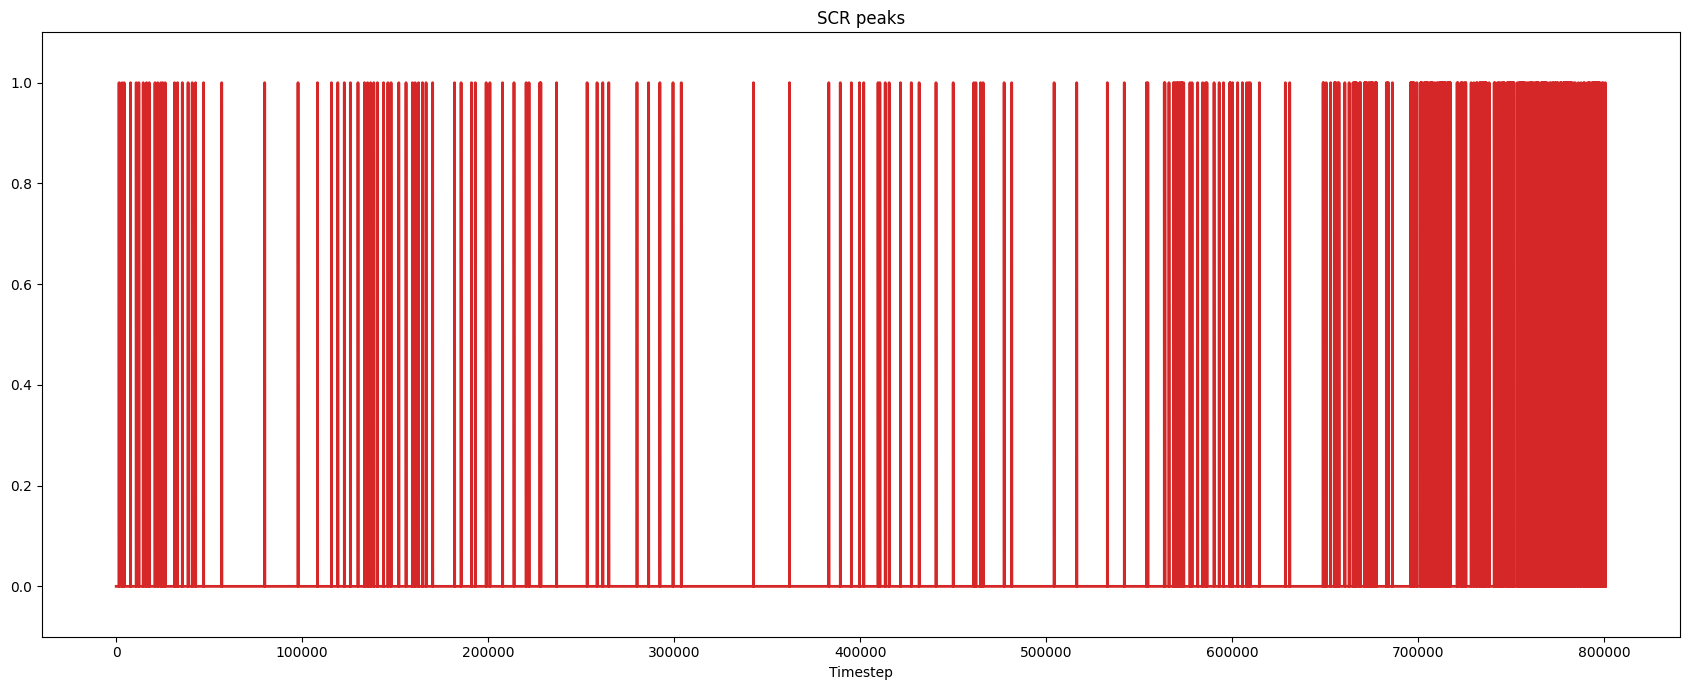

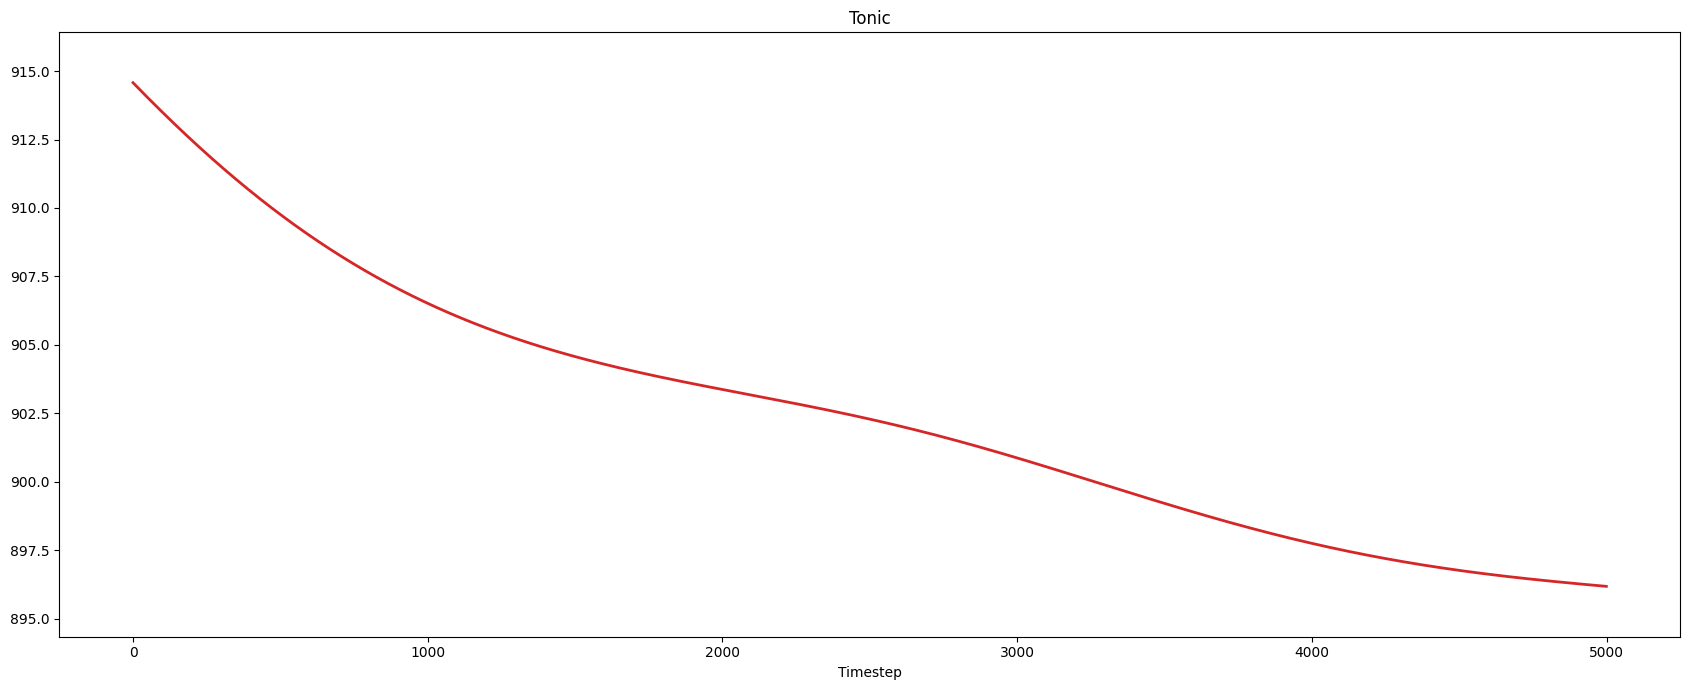

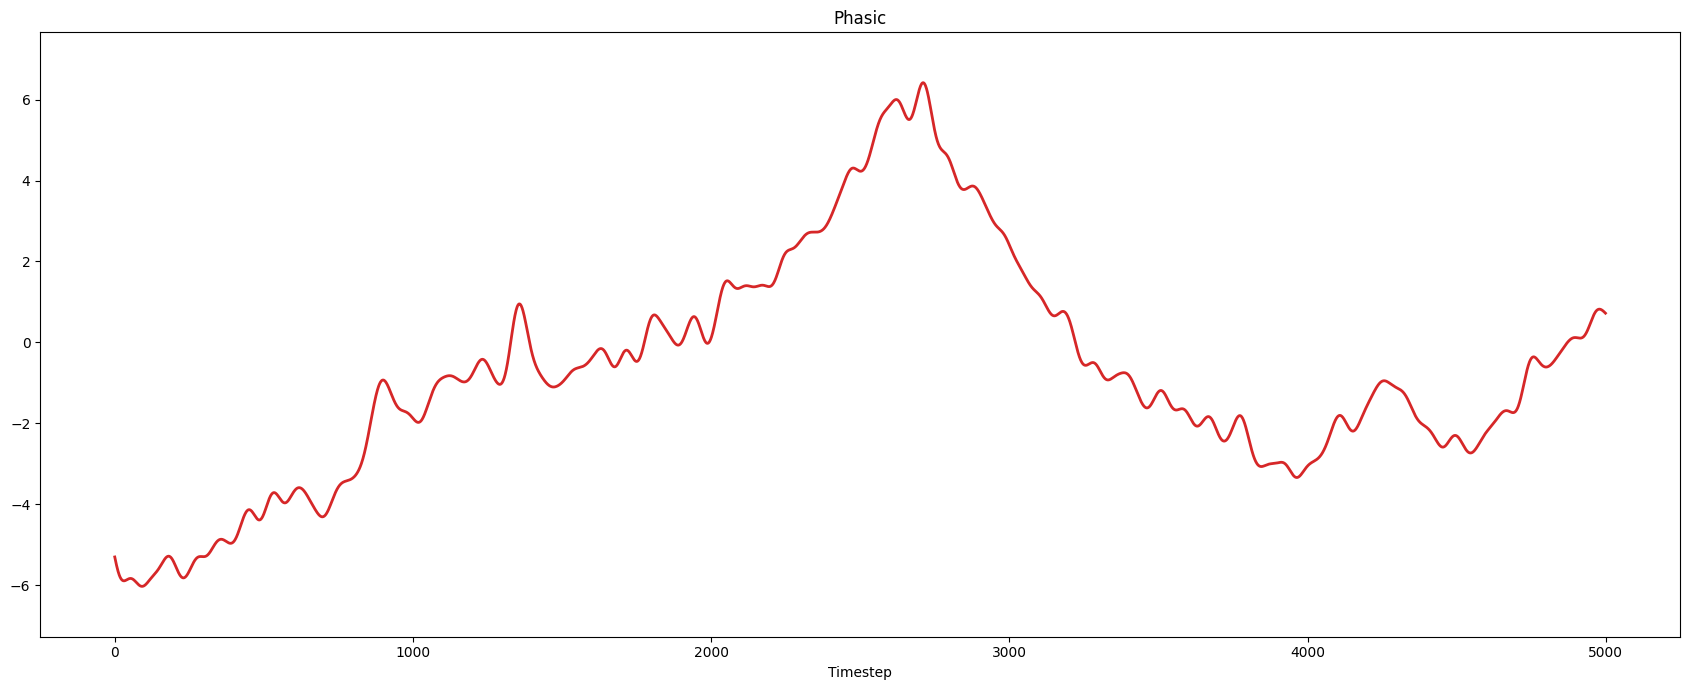

In [48]:
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
import samplerate
from biosppy.signals import ecg
from biosppy.signals import eda
from heartpy.preprocessing import scale_data


phases = [dr.Phases.PHASE_ORDER[0]]
subject_indices = [dr.SUBJECTS[0]]
fs = 250.0

for phase in phases:
    print(f"{phase}")
    data_files = {
        s: dr.Paths.WESAD + f"/S{s}/S{s}_chest_EDA_{phase}.csv" for s in subject_indices
    }
    df_dict = {s: pd.read_csv(data_files[s]) for s in list(data_files.keys())}
    for s in subject_indices:
        df = pd.read_csv(data_files[s])
        eda_signal = df.iloc[:, -1].to_numpy()

        eda_signal = scale_data(eda_signal)
        dt.plot_1d_data(eda_signal[5000:10000])

        signals, info = nk.eda_process(eda_signal, sampling_rate=fs)
        eda_signal = signals["EDA_Clean"]
        dt.plot_1d_data(eda_signal[5000:10000])

        peaks = signals["SCR_Peaks"].to_numpy()
        t = signals["EDA_Tonic"].to_numpy()
        p = signals["EDA_Phasic"].to_numpy()
        dt.plot_1d_data(peaks, title="SCR peaks")
        dt.plot_1d_data(t[5000:10000], title="Tonic")
        dt.plot_1d_data(p[5000:10000], title="Phasic")




In [17]:
# FEATURE EXTRACTION -- STATISTICAL FEATURES
# mean, median, std, variance, IQR, RMS, skewness, kurtosis
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from biosppy.signals import eda
from biosppy.signals import ecg
from heartpy.preprocessing import scale_data
from scipy.stats import iqr, skew, kurtosis


def rms(x):
    return np.sqrt(np.mean(x**2))

metrics = {
    "mean": np.nanmean,
    "median": np.nanmedian,
    "std": np.nanstd,
    "var": np.nanvar,
    "iqr": iqr,
    "rms": rms,
    "skew": skew,
    "kurtosis": kurtosis
}

phases = dr.Phases.PHASE_ORDER
subject_indices = dr.SUBJECTS
subject_indices = [str(i) for i in subject_indices]
fs = 700.0

for metric in metrics:
    for phase in phases:
        data = []
        data_files = {
            s: dr.Paths.WESAD + f"/S{s}/S{s}_chest_ECG_{phase}.csv" for s in subject_indices
        }
        df_dict = {s: pd.read_csv(data_files[s]) for s in list(data_files.keys())}
        for s in list(df_dict.keys()):
            df = df_dict[s]
            ecg_signal = df.iloc[:, -1]
            ecg_signal = scale_data(ecg_signal)
            ecg_signal = hp.filtering.remove_baseline_wander(ecg_signal, fs)
            out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=False)
            ecg_signal = out["filtered"]

            value = preprocessing.get_statistical_metrics(ecg_signal, metrics[metric], fs)
            value = np.insert(value, 0, s)
            data.append(value)

        file_name = os.path.join(dr.Paths.METRICS, f"ecg_{metric}_{phase}.csv")
        df = pd.DataFrame(data=data)
        df.to_csv(file_name)

# for metric in metrics:
#     for phase in phases:
#         data = []
#         data_files = {
#             s: dr.Paths.WESAD + f"/S{s}/S{s}_chest_EDA_{phase}.csv" for s in subject_indices
#         }
#         df_dict = {s: pd.read_csv(data_files[s]) for s in list(data_files.keys())}
#         for s in list(df_dict.keys()):
#             df = df_dict[s]
#             eda_signal = df.iloc[:, -1]
#             eda_signal = scale_data(eda_signal)
#             # out = eda.eda(signal=eda_signal, sampling_rate=fs, show=False)
#             # eda_signal = out["filtered"]
#             signals, info = nk.eda_process(eda_signal, sampling_rate=fs)
#             eda_signal = signals["EDA_Clean"].to_numpy()

#             value = preprocessing.get_statistical_metrics(eda_signal, metrics[metric], fs)
#             value = np.insert(value, 0, s)
#             data.append(value)

#         file_name = os.path.join(dr.Paths.METRICS, f"eda_{metric}_{phase}.csv")
#         df = pd.DataFrame(data=data)
#         df.to_csv(file_name)